In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
# Deep Learning
#import tensorflow as tf

In [2]:
def add_data_info():
    df1 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-m-points-from-2017.csv', encoding= 'unicode_escape', low_memory=False)
    df2 = pd.read_csv('raw_data/charting-m-matches.csv', encoding= 'unicode_escape', low_memory=False)
    
    #get separated values from m-matches list of games - based on matchid
    df = pd.merge(df1,df2[['match_id','Date','Tournament','Round','Surface','Player 1','Player 2']], on=['match_id'], how='left')
    
    #add the condition of "Grand Slam" - 5 or 3 sets
    conditions = df['Tournament'].isin(["Wimbledon", "Australian Open", "US Open", "Roland Garros"])
    values = [1,0]

    # Create a new column  based on the conditions and values
    df['Grand Slam'] = pd.Series(pd.NA)
    df.loc[conditions, 'Grand Slam'] = values[0]
    df.loc[~conditions, 'Grand Slam'] = values[1]
    
    # save the original dataset with enriched data for future features
    df.to_csv('raw_data/charting-m-points-from-2017-enriched.csv', index=False)

In [3]:
def filter_player(df,opponent):
    
    # Read the dataset into a pandas DataFrame - from enriched file
    df = pd.read_csv(df, encoding= 'unicode_escape', low_memory=False)
    
    ## filtra pelo  oponente
    df = df[(df["Player 1"].str.contains(opponent)) | (df["Player 2"].str.contains(opponent))].copy()
    
    ##define se está sacando e se ganhou o ponto
    df['i_serve'] = np.where(((df['Svr'] == 1) & (df['Player 1'] == opponent )) | ((df['Svr'] == 2) & (df['Player 2'] == opponent)), 0, 1)
    df['i_win'] = np.where(((df['isSvrWinner'] == df['i_serve'])), 1, 0)
    df['is_second_service'] = np.where(((df['2nd'].isnull())), 0, 1)
    
    ## direção do saque
    # primeiro caractere do segundo saque
    df['dir_srv'] = df.loc[:, '2nd'].str[0]
    ## completa com o primeiro caractere do primeiro saque quando ele entrou
    df['dir_srv'].fillna(df.loc[:, '1st'].str[0], inplace=True)

    
    ##reseta o indice
    df.reset_index(inplace=True)
    
    ## salva arquivo e retorna dataset da funcao
    csv_file = "raw_data/" + opponent + "_points.csv"
    df.to_csv(csv_file, index=False)
    return df

In [4]:
meaning_char = pd.read_csv('https://raw.githubusercontent.com/eduardoscovino/tennis-analytics/master/code_map.csv',
                           encoding= 'unicode_escape', sep=';')

In [5]:
add_data_info()

In [70]:
df = filter_player('raw_data/charting-m-points-from-2017-enriched.csv','Novak Djokovic')

In [71]:
## serve direction encode 
df = df[df['dir_srv'].isin(['4','5','6'])]

## to numeric for rallyCount and serve direction
df['rallyCount']=pd.to_numeric(df['rallyCount'])
df['dir_srv']=pd.to_numeric(df['dir_srv'])

In [72]:
#Spliting Serve and Return
df['rally_desc'] = df.loc[:, '2nd']
df['rally_desc'].fillna(df.loc[:, '1st'], inplace=True)

##df['Serve'] = df.loc[:, 'rally_desc'].str[0:1]

df['rally_desc'] = df['rally_desc'].str[1:]

sc = np.array(meaning_char[~meaning_char['code'].isin(['f', 'b', 'r', 's', 'v', 'l', 'o', 'z', 'p', 'u', 'y', 'h', 'i', 'j', 'k','m', '1', '2', '3', '7', '8', '9'])]['code'])

#Spliting every shot
df['rally_desc'] = df['rally_desc'].apply(lambda x: ''.join([c for c in x if c not in sc]))
df['rally_desc'] = df['rally_desc'].str.replace('f',' f').str.replace('b',' b').str.replace('s',' s').str.replace('r',' r').str.replace('v',' v').str.replace('l',' l').str.replace('o',' o').str.replace('z',' z').str.replace('p',' p').str.replace('u',' u').str.replace('y',' y').str.replace('h',' h').str.replace('i',' i').str.replace('j',' j').str.replace('k',' k').str.replace('m',' m').str.replace('!','').str.replace('+','').str.replace(';','').str.replace('^','').str.replace('C','')
df['rally_desc'] = df['rally_desc'].map(lambda x: x.lstrip(' ').rstrip(' '))

/var/folders/kk/0r0_hyfd673456ly0hptrbsc0000gn/T/ipykernel_21546/2934495866.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['rally_desc'] = df['rally_desc'].str.replace('f',' f').str.replace('b',' b').str.replace('s',' s').str.replace('r',' r').str.replace('v',' v').str.replace('l',' l').str.replace('o',' o').str.replace('z',' z').str.replace('p',' p').str.replace('u',' u').str.replace('y',' y').str.replace('h',' h').str.replace('i',' i').str.replace('j',' j').str.replace('k',' k').str.replace('m',' m').str.replace('!','').str.replace('+','').str.replace(';','').str.replace('^','').str.replace('C','')


In [73]:
df.head()

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc
0,637,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,4n,4f18f3s2f1f3b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,2,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,1,1,4,f18 f3 s2 f1 f3 b3
1,638,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,2,0,0,0,0,0-15,1 (2),1,0,NaN,1,2,ND,4n,6f2n#,NaN,0,0.0,0,1.0,False,False,False,True,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,6,f2
2,639,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4*,NaN,Failed Ruud challenge,0,NaN,1,NaN,True,False,False,False,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,
3,640,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,4,0,0,0,0,30-15,1 (4),1,0,NaN,1,2,ND,4n,5b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,5,b3
4,641,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,5,0,0,0,0,40-15,1 (5),1,0,NaN,1,2,ND,4r28f1r2f3b3f2f1f1f3b3b3b1r2n#,NaN,NaN,0,NaN,1,NaN,False,False,False,True,False,False,1,1,13,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,r28 f1 r2 f3 b3 f2 f1 f1 f3 b3 b3 b1 r2


In [74]:
df['isUnforced'] = df['isUnforced'].replace({True: 1, False: 0})
df['isForced'] = df['isForced'].replace({True: 1, False: 0})
df['serve_return'] = df['rally_desc'].map(lambda x: x.split(' ')).str[0]

In [75]:
# df['end']
df['how_ended'] = df.loc[:, '2nd'].str[-1]
df['how_ended'].fillna(df.loc[:, '1st'].str[-1], inplace=True)

df.head()

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,serve_return,how_ended
0,637,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,4n,4f18f3s2f1f3b3n@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,1,1,4,f18 f3 s2 f1 f3 b3,f18,@
1,638,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,2,0,0,0,0,0-15,1 (2),1,0,NaN,1,2,ND,4n,6f2n#,NaN,0,0.0,0,1.0,False,False,False,1,0,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,6,f2,f2,#
2,639,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4*,NaN,Failed Ruud challenge,0,NaN,1,NaN,True,False,False,0,0,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,,,*
3,640,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,4,0,0,0,0,30-15,1 (4),1,0,NaN,1,2,ND,4n,5b3n@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,5,b3,b3,@
4,641,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,5,0,0,0,0,40-15,1 (5),1,0,NaN,1,2,ND,4r28f1r2f3b3f2f1f1f3b3b3b1r2n#,NaN,NaN,0,NaN,1,NaN,False,False,False,1,0,False,1,1,13,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,r28 f1 r2 f3 b3 f2 f1 f1 f3 b3 b3 b1 r2,r28,#


In [76]:
df_serve = df[df['i_serve']==1]
df_serve.head()

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,serve_return,how_ended
5,642,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,6,0,0,1,0,0-0,2 (1),1,0,NaN,2,1,CR,4n,6b37b2f3s2f1f1f3w@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,7,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,1,1,6,b37 b2 f3 s2 f1 f1 f3,b37,@
6,643,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,7,0,0,1,0,15-0,2 (2),1,0,NaN,2,1,CR,4n,5b38s3b3b3b3b3b1*,NaN,0,0.0,0,1.0,False,False,True,0,0,False,1,0,8,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,5,b38 s3 b3 b3 b3 b3 b1,b38,*
7,644,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,8,0,0,1,0,15-15,2 (3),1,0,NaN,2,1,CR,6n,5f28f3s2f+3b2v1d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,5,f28 f3 s2 f3 b2 v1,f28,@
8,645,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,9,0,0,1,0,15-30,2 (4),1,0,NaN,2,1,CR,4d,6f38f3b2f1f2f3d@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,6,f38 f3 b2 f1 f2 f3,f38,@
9,646,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,10,0,0,1,0,15-40,2 (5),1,0,NaN,2,1,CR,6d,5b3w@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,1,1,5,b3,b3,@


In [77]:
df_receive = df[df['i_serve']!=1]
df_receive.head()

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,serve_return,how_ended
0,637,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,4n,4f18f3s2f1f3b3n@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,1,1,4,f18 f3 s2 f1 f3 b3,f18,@
1,638,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,2,0,0,0,0,0-15,1 (2),1,0,NaN,1,2,ND,4n,6f2n#,NaN,0,0.0,0,1.0,False,False,False,1,0,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,6,f2,f2,#
2,639,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4*,NaN,Failed Ruud challenge,0,NaN,1,NaN,True,False,False,0,0,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,,,*
3,640,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,4,0,0,0,0,30-15,1 (4),1,0,NaN,1,2,ND,4n,5b3n@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,5,b3,b3,@
4,641,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,5,0,0,0,0,40-15,1 (5),1,0,NaN,1,2,ND,4r28f1r2f3b3f2f1f1f3b3b3b1r2n#,NaN,NaN,0,NaN,1,NaN,False,False,False,1,0,False,1,1,13,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,r28 f1 r2 f3 b3 f2 f1 f1 f3 b3 b3 b1 r2,r28,#


## Dataset separados  - servindo ou recebendo ##

In [78]:
df_serve['serve_return'].nunique()

72

In [79]:
df_receive['serve_return'].nunique()

77

In [80]:
##df = df[df['serve_return']!=""]

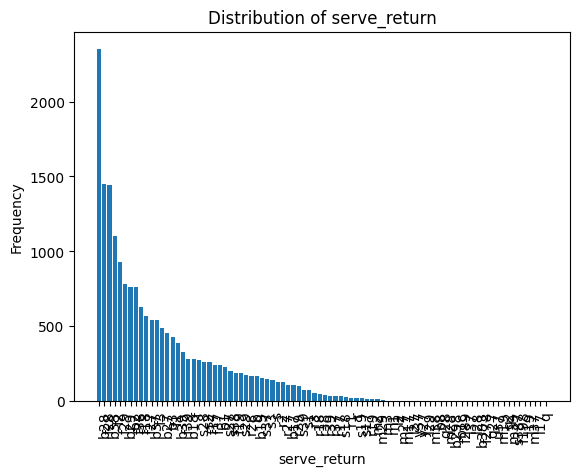

In [81]:
serve_return_column = df["serve_return"]
value_counts = serve_return_column.value_counts()

plt.bar(value_counts.index, value_counts.values )
plt.xlabel("serve_return")
plt.ylabel("Frequency")
plt.title("Distribution of serve_return")
plt.xticks(rotation=90)
plt.show()

In [82]:
serve_return_counts = df["serve_return"].value_counts().reset_index()
serve_return_counts.columns = ["serve_return", "frequency"]
serve_return_counts = serve_return_counts.sort_values("frequency", ascending=False )

serve_return_counts.head(10)


,serve_return,frequency
0,,2348
1,b28,1453
2,f28,1443
3,b38,1105
4,f2,927
5,f29,782
6,b29,766
7,b2,761
8,f38,627
9,f18,567


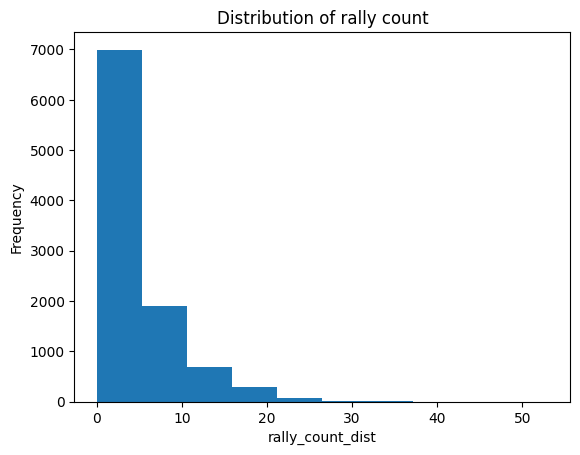

In [83]:
rally_count_dist = df_serve["rallyCount"]
rally_count_dist = rally_count_dist.dropna()

plt.hist(rally_count_dist)
plt.xlabel("rally_count_dist")
plt.ylabel("Frequency")
plt.title("Distribution of rally count")
plt.show()

In [84]:
rally_counts = df_serve["rallyCount"].value_counts().reset_index()
rally_counts.columns = ["rally_counts", "frequency"]
rally_counts = rally_counts.sort_values("frequency", ascending=False )

print(rally_counts)

    rally_counts  frequency
0              1       2671
1              3       1340
2              2       1070
3              5        784
4              4        773
5              6        579
6              7        444
7              8        382
8              0        358
9              9        269
10            10        234
11            12        181
12            11        177
13            13        126
14            14        120
15            16         87
16            15         76
17            17         57
18            18         51
19            19         40
20            20         32
21            22         25
22            21         21
23            23         16
24            25         15
25            24         12
26            28          5
27            26          5
29            30          4
28            27          4
30            29          3
31            31          3
32            34          2
33            32          2
34            35    

## Geração das features

In [127]:
features = ['Surface',
            'Round',
            'Grand Slam',
            'dir_srv',
            'rallyCount',
            'isUnforced',
            'isForced',
            "serve_return",
            "how_ended"
            ]
X_serve = df_serve[features]
y_serve = df_serve['i_win']

X_receive = df_receive[features]
y_receive = df_receive['i_win']

In [128]:
feat_categorical = ['Surface','Round','dir_srv','serve_return','how_ended']

In [129]:
X_serve.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9973 entries, 5 to 19317
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Surface       9973 non-null   object
 1   Round         9973 non-null   object
 2   Grand Slam    9973 non-null   int64 
 3   dir_srv       9973 non-null   int64 
 4   rallyCount    9973 non-null   int64 
 5   isUnforced    9973 non-null   int64 
 6   isForced      9973 non-null   int64 
 7   serve_return  9973 non-null   object
 8   how_ended     9973 non-null   object
dtypes: int64(5), object(4)
memory usage: 779.1+ KB


In [130]:
X_receive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8778 entries, 0 to 19323
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Surface       8778 non-null   object
 1   Round         8778 non-null   object
 2   Grand Slam    8778 non-null   int64 
 3   dir_srv       8778 non-null   int64 
 4   rallyCount    8778 non-null   int64 
 5   isUnforced    8778 non-null   int64 
 6   isForced      8778 non-null   int64 
 7   serve_return  8778 non-null   object
 8   how_ended     8778 non-null   object
dtypes: int64(5), object(4)
memory usage: 685.8+ KB


## separação - treino, teste e validação

In [131]:
from sklearn.model_selection import train_test_split

# Train-Test Split - ## parametro stratify ###
s_train, s_test = train_test_split(df_serve, test_size=0.25)
r_train, r_test = train_test_split(df_receive, test_size=0.25)

# Train-Val Split
s_train, s_val = train_test_split(s_train, test_size=0.25)
r_train, r_val = train_test_split(r_train, test_size=0.25)


In [132]:
## Separating features and target in the Train, Val and Test Set

X_s_train = s_train[features]
y_s_train = s_train['i_win']

X_r_train = r_train[features]
y_r_train = r_train['i_win']

X_s_val = s_val[features]
y_s_val = s_val['i_win']

X_r_val = r_val[features]
y_r_val = r_val['i_win']

X_s_test = s_test[features]
y_s_test = s_test['i_win']

X_r_test = r_test[features]
y_r_test = r_test['i_win']

In [133]:
print(len(s_train), 'serving train examples')
print(len(s_val), 'serving validation examples')
print(len(s_test), 'serving test examples')
print('############')
print(len(r_train), 'receiving train examples')
print(len(r_val), 'receiving validation examples')
print(len(r_test), 'receiving test examples')

5609 serving train examples
1870 serving validation examples
2494 serving test examples
############
4937 receiving train examples
1646 receiving validation examples
2195 receiving test examples


In [134]:
X_s_train['serve_return'].nunique()

64

## Inicio do modelo - pre processamento e encoder

In [135]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config(display="diagram")

In [136]:
preproc = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=["object"])),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include=["object"]))
)

preproc

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16d836a10>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16d8352a0>)])

In [137]:
preproc.fit_transform(X_s_train).shape

(5609, 91)

In [138]:
preproc.fit_transform(X_r_train).shape

(4937, 97)

In [139]:
X_s_train_preproc = preproc.fit_transform(X_s_train)
X_s_val_preproc = preproc.transform(X_s_val)
X_s_test_preproc = preproc.transform(X_s_test)

In [140]:
X_r_train_preproc = preproc.fit_transform(X_r_train)
X_r_val_preproc = preproc.transform(X_r_val)
X_r_test_preproc = preproc.transform(X_r_test)

## Definição do modelo

In [141]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

########## serving model #####################

In [142]:
model_s = Sequential()

# 1. Architecture
model_s.add(layers.Dense(32, activation='relu', input_shape=(X_s_train_preproc.shape[-1],)))
model_s.add(layers.Dropout(0.2))
model_s.add(layers.Dense(15, activation='relu'))
model_s.add(layers.Dropout(0.3))
model_s.add(layers.Dense(1, activation='sigmoid'))

# 2. Compiling
model_s.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

########## receiving model #####################

In [143]:
model_r = Sequential()

# 1. Architecture
model_r.add(layers.Dense(32, activation='relu', input_shape=(X_r_train_preproc.shape[-1],)))
model_r.add(layers.Dropout(0.2))
model_r.add(layers.Dense(15, activation='relu'))
model_r.add(layers.Dropout(0.3))
model_r.add(layers.Dense(1, activation='sigmoid'))

# 2. Compiling
model_r.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [144]:
# 3. Training

es = EarlyStopping(monitor = 'val_accuracy',
                   patience = 5,
                   verbose = 0,
                   restore_best_weights = True)

In [145]:
#### trainning serving model
history_s = model_s.fit(X_s_train_preproc,
                   y_s_train,
                   validation_data = (X_s_val_preproc, y_s_val),
                   batch_size = 64,
                   epochs = 500,
                   callbacks = [es], 
                   verbose = 1)



Epoch 1/500
88/88 [==============================] - 0s 1ms/step - loss: 0.6546 - accuracy: 0.6056 - val_loss: 0.6090 - val_accuracy: 0.6567
Epoch 2/500
88/88 [==============================] - 0s 543us/step - loss: 0.6077 - accuracy: 0.6554 - val_loss: 0.5670 - val_accuracy: 0.6866
Epoch 3/500
88/88 [==============================] - 0s 520us/step - loss: 0.5733 - accuracy: 0.6844 - val_loss: 0.5305 - val_accuracy: 0.7203
Epoch 4/500
88/88 [==============================] - 0s 523us/step - loss: 0.5450 - accuracy: 0.6999 - val_loss: 0.5011 - val_accuracy: 0.7246
Epoch 5/500
88/88 [==============================] - 0s 529us/step - loss: 0.5185 - accuracy: 0.7238 - val_loss: 0.4796 - val_accuracy: 0.7353
Epoch 6/500
88/88 [==============================] - 0s 534us/step - loss: 0.5006 - accuracy: 0.7304 - val_loss: 0.4667 - val_accuracy: 0.7396
Epoch 7/500
88/88 [==============================] - 0s 556us/step - loss: 0.4879 - accuracy: 0.7310 - val_loss: 0.4584 - val_accuracy: 0.7433
E

In [146]:
#### trainning receiving model
history_r = model_r.fit(X_r_train_preproc,
                   y_r_train,
                   validation_data = (X_r_val_preproc, y_r_val),
                   batch_size = 64,
                   epochs = 500,
                   callbacks = [es], 
                   verbose = 1)

Epoch 1/500
78/78 [==============================] - 0s 1ms/step - loss: 0.6689 - accuracy: 0.5866 - val_loss: 0.6000 - val_accuracy: 0.6780
Epoch 2/500
78/78 [==============================] - 0s 546us/step - loss: 0.5952 - accuracy: 0.6771 - val_loss: 0.5690 - val_accuracy: 0.6738
Epoch 3/500
78/78 [==============================] - 0s 541us/step - loss: 0.5708 - accuracy: 0.6775 - val_loss: 0.5463 - val_accuracy: 0.6920
Epoch 4/500
78/78 [==============================] - 0s 545us/step - loss: 0.5432 - accuracy: 0.7002 - val_loss: 0.5245 - val_accuracy: 0.7102
Epoch 5/500
78/78 [==============================] - 0s 545us/step - loss: 0.5273 - accuracy: 0.7069 - val_loss: 0.5059 - val_accuracy: 0.7193
Epoch 6/500
78/78 [==============================] - 0s 526us/step - loss: 0.5108 - accuracy: 0.7071 - val_loss: 0.4943 - val_accuracy: 0.7187
Epoch 7/500
78/78 [==============================] - 0s 520us/step - loss: 0.4949 - accuracy: 0.7245 - val_loss: 0.4850 - val_accuracy: 0.7193
E

## Resultado final / evaluate

In [147]:
res_s = model_s.evaluate(X_s_test_preproc, y_s_test)
print(f"accuracy = {res_s[1]:.3f}")

78/78 [==============================] - 0s 348us/step - loss: 0.4757 - accuracy: 0.7406
accuracy = 0.741


In [148]:
model_s.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                2944      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 15)                495       
                                                                 
 dropout_9 (Dropout)         (None, 15)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 16        
                                                                 
Total params: 3,455
Trainable params: 3,455
Non-trainable params: 0
_________________________________________________________________


In [149]:
res_r = model_r.evaluate(X_r_test_preproc, y_r_test)
print(f"accuracy = {res_r[1]:.3f}")

69/69 [==============================] - 0s 337us/step - loss: 0.4655 - accuracy: 0.7312
accuracy = 0.731


In [150]:
model_r.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                3136      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 15)                495       
                                                                 
 dropout_11 (Dropout)        (None, 15)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 16        
                                                                 
Total params: 3,647
Trainable params: 3,647
Non-trainable params: 0
_________________________________________________________________


## Verificação loss/accuracy - overfit / underfit

In [151]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

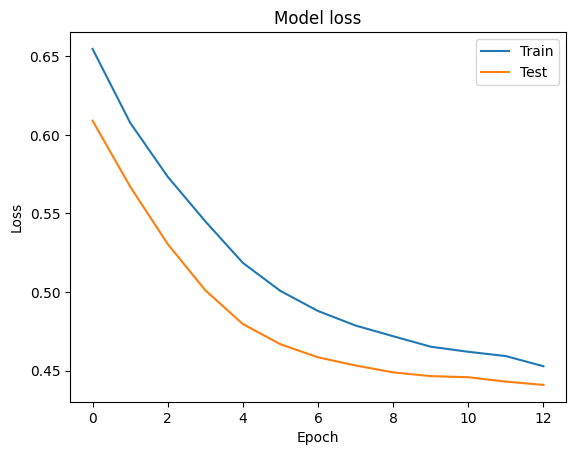

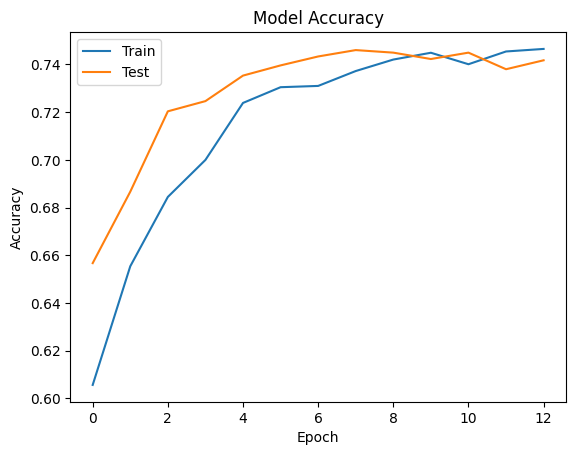

In [152]:
plot_loss_accuracy(history_s)

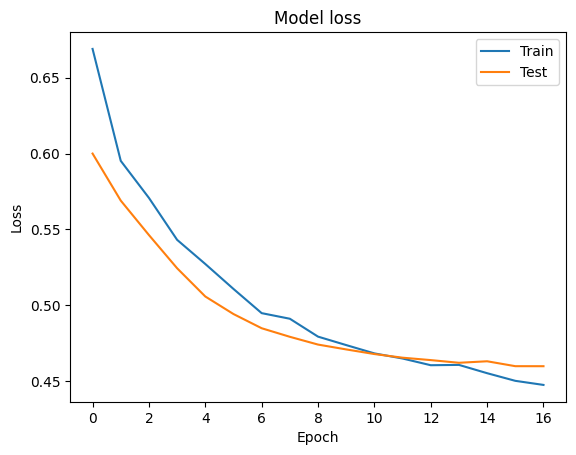

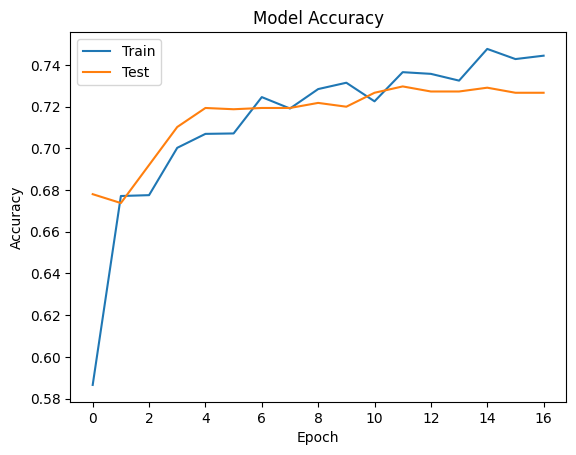

In [153]:
plot_loss_accuracy(history_r)